# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [14]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# Check if auto-reload is available
print(f"Auto-reload available: {afml.AUTO_RELOAD_AVAILABLE}")

# Setup with auto-reload enabled
app = afml.setup_jupyter(enable_auto_reload=True)

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-10-27 06:01:15.655 | INFO     | afml:setup_jupyter:215 - Setting up AFML for Jupyter notebook...
2025-10-27 06:01:15.665 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache


Reloading 'afml.strategies.bollinger_features'.
Reloading 'afml.features.moving_averages'.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Auto-reload available: True


2025-10-27 06:01:15.670 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-10-27 06:01:15.670 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-10-27 06:01:15.675 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-27 06:01:15.675 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 4 functions, 37.3% hit rate
2025-10-27 06:01:15.680 | INFO     | afml.cache.auto_reload:start_watching:52 - Watching for changes: C:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks
2025-10-27 06:01:15.690 | INFO     | afml:setup_jupyter:224 - Auto-reload enabled
2025-10-27 06:01:15.695 | INFO     | afml:setup_jupyter:238 - Cache ready: 37.3% hit rate


Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [15]:
import warnings
import winsound

from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from afml.cache import cache_maintenance
from afml.cross_validation.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    ml_cross_val_score,
    ml_cross_val_scores_all,
)
from afml.data_structures.bars import *
from afml.labeling import (
    add_vertical_barrier,
    get_event_weights,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    login_mt5,
    get_bars,
)
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
)
from afml.util import (
    get_daily_vol,
    value_counts_data,
)   

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
# plt.style.use("dark_background")

## 1. Data Preparation

In [16]:
symbol = "EURUSD"
start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2022-12-31"        

## 2. Bollinger Band Strategy

In [17]:
bb_timeframe = "M5"
file = Path(r"..\data\EURUSD_M5_time_2018-01-01-2024-12-31.parq")
bb_time_bars = pd.read_parquet(file)

In [18]:
bb_period, bb_std = 20, 2 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1, 2, dict(days=1))
min_ret = 0.0
bb_vol_multiplier = 1

### Time-Bars

In [19]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 20
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close
_, t_events = get_entries(bb_strategy, bb_df, filter_threshold=vol_target.mean())

vertical_barriers = add_vertical_barrier(t_events, close, **bb_time_horizon)

Bollinger_w20_std2 Signals:

        count  proportion
side                     
 0    310,455    0.840146
-1     29,598    0.080097
 1     29,472    0.079756



2025-10-27 06:01:20.822 | INFO     | afml.filters.filters:cusum_filter:151 - 40,787 CUSUM-filtered events
2025-10-27 06:01:20.915 | INFO     | afml.strategies.signal_processing:get_entries:105 - Bollinger_w20_std2 | 14,459 (24.48%) trade events selected by CUSUM filter (threshold = 0.0696%).


#### Feature Engineering

In [20]:
bb_feat = create_bollinger_features(bb_time_bars, bb_period, bb_std)
bb_feat_time = bb_feat.copy()
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

2025-10-27 06:01:21.769 | DEBUG    | afml.cache.selective_cleaner:track_function:112 - Function changed: afml.strategies.bollinger_features.create_bollinger_features
2025-10-27 06:01:22.291 | DEBUG    | afml.cache.selective_cleaner:_clear_function_caches:309 - Cleared cache directory: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache\joblib\afml\strategies\bollinger_features\create_bollinger_features
2025-10-27 06:01:22.296 | INFO     | afml.cache.selective_cleaner:wrapper:350 - Auto-cleared changed function cache: afml.strategies.bollinger_features.create_bollinger_features
2025-10-27 06:01:29.865 | INFO     | afml.features.moving_averages:calculate_ma_differences:42 - 
Dropped features with correlation > 0.75: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200']
Kept features: 
	['sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516825 entries, 2018-01-02 23:20:00 to 2024-12-31 00:00:00
Data columns (total 52 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   spread               516825 non-null  float32
 1   vol                  516825 non-null  float32
 2   h1_vol               516825 non-null  float32
 3   h4_vol               516825 non-null  float32
 4   d1_vol               516825 non-null  float32
 5   ret                  516825 non-null  float32
 6   ret_5                516825 non-null  float32
 7   ret_10               516825 non-null  float32
 8   ret_1_lag_1          516825 non-null  float32
 9   ret_5_lag_1          516825 non-null  float32
 10  ret_10_lag_1         516825 non-null  float32
 11  ret_1_lag_2          516825 non-null  float32
 12  ret_5_lag_2          516825 non-null  float32
 13  ret_10_lag_2         516825 non-null  float32
 14  ret_1_lag_3          516825 non-nu

#### Triple-Barrier Method

In [21]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'days': 1}):

     count  proportion
bin                   
-1   7,102         0.5
 1   7,102         0.5

Average Uniqueness: 0.7994


In [22]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time_meta = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'days': 1}):

     count  proportion
bin                   
1    9,402    0.650838
0    5,044    0.349162

Average Uniqueness: 0.6315


#### Cross-Validation of Weighting Methods

##### Primary Model 

In [23]:
cont = bb_events_tb_time.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2
n_splits = 10
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close)
bb_cont_train = cont_train.copy()

In [24]:
avg_u = cont_train.tW.mean()
print(f"Average Uniqueness in Training Set: {avg_u:.4f}")
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

decay_factors = [0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

Average Uniqueness in Training Set: 0.8193


dict_keys(['unweighted', 'uniqueness', 'return'])

In [25]:
random_state = 42
min_w_leaf = 0.05


rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')

clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}
clfs

{'standard': RandomForestClassifier(criterion='entropy', min_weight_fraction_leaf=0.05,
                        n_jobs=-1, random_state=42),
 'balanced_subsample': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        min_weight_fraction_leaf=0.05, n_jobs=-1,
                        random_state=42),
 'max_samples': RandomForestClassifier(criterion='entropy', max_samples=0.8193019128311877,
                        min_weight_fraction_leaf=0.05, n_jobs=-1,
                        random_state=42),
 'combined': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        max_samples=0.8193019128311877,
                        min_weight_fraction_leaf=0.05, n_jobs=-1,
                        random_state=42)}

In [26]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {k: {} for k in clfs.keys()}
print(rf.__class__.__name__, "Weighting Schemes")
all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_models = []

for scheme, sample_weights in weighting_schemes.items():
    best_score, best_model = None, None
    for param, clf in clfs.items():
        w = sample_weights.values
        cv_scores = ml_cross_val_score(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=w, 
            sample_weight_score=w,
            scoring="log_loss",
        )
        score = cv_scores.mean()
        cv_scores_d[param][scheme] = score
        best_score = max(best_score, score) if best_score is not None else score
        if score == best_score:
            best_model = param
        all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
    best_models.append(best_model)
    print(f"{scheme} {best_model} model achieved the best neg_log_loss score of {best_score:.6f}.")

print()
pprint(all_clf_scores_df, sort_dicts=False)
best_model = max(best_models, key=best_models.count)
best_clf = clone(clfs[best_model])
print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

RandomForestClassifier Weighting Schemes
unweighted balanced_subsample model achieved the best neg_log_loss score of -0.691693.
uniqueness combined model achieved the best neg_log_loss score of -0.690717.
return balanced_subsample model achieved the best neg_log_loss score of -0.643201.

                            unweighted          uniqueness              return
standard            -0.691826 ± 0.0015  -0.690970 ± 0.0013  -0.643280 ± 0.0058
balanced_subsample  -0.691693 ± 0.0015  -0.690832 ± 0.0012  -0.643201 ± 0.0058
max_samples         -0.692046 ± 0.0016  -0.690862 ± 0.0013  -0.643707 ± 0.0061
combined            -0.691907 ± 0.0016  -0.690717 ± 0.0011  -0.643621 ± 0.0060

Selected Best Classifier (balanced_subsample): RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       min_weight_fraction_leaf=0.05, n_jobs=-1,
                       random_state=42)


In [27]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = ml_cross_val_scores_all(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores['neg_log_loss'].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best neg_log_loss score of {best_score:.6f}.\n")

                   unweighted       uniqueness           return
accuracy       0.5264 ± 0.011   0.5345 ± 0.009   0.6556 ± 0.009
pwa            0.5324 ± 0.014   0.5388 ± 0.008   0.6640 ± 0.011
neg_log_loss  -0.6917 ± 0.002  -0.6908 ± 0.001  -0.6432 ± 0.006
precision      0.5243 ± 0.015   0.5317 ± 0.019   0.6452 ± 0.027
recall         0.5578 ± 0.033   0.5643 ± 0.032   0.6414 ± 0.023
f1             0.5397 ± 0.014   0.5465 ± 0.011   0.6431 ± 0.022

return model achieved the best neg_log_loss score of -0.643201.



In [28]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 299.0, 'FP': 275.0, 'FN': 262.0, 'TP': 301.0},
                {'fold': 2, 'TN': 273.0, 'FP': 328.0, 'FN': 226.0, 'TP': 310.0},
                {'fold': 3, 'TN': 279.0, 'FP': 292.0, 'FN': 238.0, 'TP': 328.0},
                {'fold': 4, 'TN': 292.0, 'FP': 290.0, 'FN': 233.0, 'TP': 322.0},
                {'fold': 5, 'TN': 261.0, 'FP': 295.0, 'FN': 250.0, 'TP': 330.0},
                {'fold': 6, 'TN': 289.0, 'FP': 266.0, 'FN': 275.0, 'TP': 306.0},
                {'fold': 7, 'TN': 292.0, 'FP': 245.0, 'FN': 309.0, 'TP': 290.0},
                {'fold': 8, 'TN': 305.0, 'FP': 272.0, 'FN': 245.0, 'TP': 314.0},
                {'fold': 9, 'TN': 277.0, 'FP': 311.0, 'FN': 217.0, 'TP': 331.0},
                {'fold': 10,
                 'TN': 258.0,
                 'FP': 297.0,
                 'FN': 256.0,
                 'TP': 325.0}],
 'uniqueness': [{'fold': 1,
                 'TN': 234.78,
                 'FP': 228.22,
                 'FN': 203.79,

##### Meta-Labelled

In [29]:
cont = bb_events_tb_time_meta.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2
n_splits = 10
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close)
bb_cont_train_meta = cont_train.copy()

In [30]:
avg_u = cont_train.tW.mean()
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

decay_factors = [0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [31]:
random_state = 42
min_w_leaf = 0.05
print(f"Average uniqueness: {avg_u:.4f}\n")
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')
clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}

Average uniqueness: 0.6538



In [ ]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {k: {} for k in clfs.keys()}
print(rf.__class__.__name__, "Weighting Schemes")
all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_models = []

for scheme, sample_weights in weighting_schemes.items():
    best_score, best_model = None, None
    for param, clf in clfs.items():
        w = sample_weights.values
        cv_scores = ml_cross_val_score(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=w, 
            sample_weight_score=w,
            scoring="f1",
        )
        score = cv_scores.mean()
        cv_scores_d[param][scheme] = score
        best_score = max(best_score, score) if best_score is not None else score
        if score == best_score:
            best_model = param
        all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
    best_models.append(best_model)
    print(f"{scheme} {best_model} model achieved the best f1 score of {best_score:.6f}")

print()
pprint(all_clf_scores_df, sort_dicts=False)
best_model = max(best_models, key=best_models.count)
best_clf = clone(clfs[best_model])
print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

RandomForestClassifier Weighting Schemes
unweighted max_samples model achieved the best f1 score of 0.786447.
uniqueness max_samples model achieved the best f1 score of 0.795146.
return combined model achieved the best f1 score of 0.000000.

                           unweighted         uniqueness             return
standard            0.786447 ± 0.0125  0.795146 ± 0.0106  0.000000 ± 0.0000
balanced_subsample  0.596072 ± 0.0481  0.726919 ± 0.0162  0.000000 ± 0.0000
max_samples         0.786447 ± 0.0125  0.795146 ± 0.0106  0.000000 ± 0.0000
combined            0.597667 ± 0.0513  0.729129 ± 0.0256  0.000000 ± 0.0000

Selected Best Classifier (max_samples): RandomForestClassifier(criterion='entropy', max_samples=0.6537650779739149,
                       min_weight_fraction_leaf=0.05, n_jobs=-1,
                       random_state=42)


In [ ]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = ml_cross_val_scores_all(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores['f1'].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best f1 score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.6482 ± 0.017   0.6601 ± 0.015   0.6534 ± 0.010
pwa            0.6489 ± 0.018   0.6604 ± 0.016   0.6645 ± 0.009
neg_log_loss  -0.6489 ± 0.011  -0.6417 ± 0.011  -0.6419 ± 0.005
precision      0.6482 ± 0.017   0.6601 ± 0.015   0.0000 ± 0.000
recall         1.0000 ± 0.000   1.0000 ± 0.000   0.0000 ± 0.000
f1             0.7864 ± 0.013   0.7951 ± 0.011   0.0000 ± 0.000

uniqueness model achieved the best f1 score of 0.795146.



In [34]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 0.0, 'FP': 370.0, 'FN': 0.0, 'TP': 786.0},
                {'fold': 2, 'TN': 0.0, 'FP': 424.0, 'FN': 0.0, 'TP': 732.0},
                {'fold': 3, 'TN': 0.0, 'FP': 414.0, 'FN': 0.0, 'TP': 742.0},
                {'fold': 4, 'TN': 0.0, 'FP': 387.0, 'FN': 0.0, 'TP': 768.0},
                {'fold': 5, 'TN': 0.0, 'FP': 409.0, 'FN': 0.0, 'TP': 746.0},
                {'fold': 6, 'TN': 0.0, 'FP': 427.0, 'FN': 0.0, 'TP': 728.0},
                {'fold': 7, 'TN': 0.0, 'FP': 410.0, 'FN': 0.0, 'TP': 745.0},
                {'fold': 8, 'TN': 0.0, 'FP': 411.0, 'FN': 0.0, 'TP': 744.0},
                {'fold': 9, 'TN': 0.0, 'FP': 380.0, 'FN': 0.0, 'TP': 775.0},
                {'fold': 10, 'TN': 0.0, 'FP': 432.0, 'FN': 0.0, 'TP': 723.0}],
 'uniqueness': [{'fold': 1, 'TN': 0.0, 'FP': 229.55, 'FN': 0.0, 'TP': 505.32},
                {'fold': 2, 'TN': 0.0, 'FP': 250.59, 'FN': 0.0, 'TP': 452.34},
                {'fold': 3, 'TN': 0.0, 'FP': 248.73, 'FN': 0.0, 'TP': 

#### Sequential Bootstrap

In [23]:
from sklearn.tree import DecisionTreeClassifier


min_w_leaf = 0.05

# More straightforward and gives you better control
base_tree = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    
    # Pre-pruning parameters
    min_weight_fraction_leaf=min_w_leaf,
    # max_depth=10,
    # min_samples_split=20,
    # min_samples_leaf=10,
)
base_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1,
    bootstrap=False,
    class_weight='balanced_subsample',
    min_weight_fraction_leaf=min_w_leaf,
    )

In [24]:
value_counts_data(cont_train.bin)

,count,proportion
bin,,
1,"7,489",0.64823
0,"4,064",0.35177


In [25]:
from afml.sampling.optimized_sb_bagging import SequentiallyBootstrappedBaggingClassifier


t = slice(0, None)
idx = y_train.index[t]
t1_train = cont_train.loc[idx, 't1']
w_train = cont_train.loc[idx, "tW"]
cv_gen = PurgedKFold(t1=t1_train, pct_embargo=0.01)

seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=t1_train,
    price_bars_index=bb_df.index,
    estimator=base_tree,
    n_estimators=50,
    oob_score=True,
    max_samples=avg_u,
    n_jobs=3,
    random_state=42,
    verbose=0,
)
# seq_rf.fit(
#     X_train.iloc[t, :],
#     y_train.iloc[t],
#     sample_weight=w_train.values,
# )
# print(f"Out-of-Bag Score: {seq_rf.oob_score_:.4f}")

In [26]:
all_scores, all_scores_df = ml_cross_val_scores_all(
    classifier=seq_rf, 
    X=X_train.iloc[t, :],
    y=y_train.iloc[t],
    cv_gen=cv_gen,
    sample_weight_train=w_train,
    sample_weight_score=w_train,
    )
all_scores_df.round(4)

TypeError: expecting {i8*, i8*, i64, i64, i32*, [1 x i64], [1 x i64]} but got {i8*, i8*, i64, i64, i64*, [1 x i64], [1 x i64]}

In [ ]:
winsound.Beep(1000, 1000)

## 3. Moving Average Crossover Strategy

In [65]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M5"
file = Path(r"..\data\EURUSD_M15_time_2018-01-01-2024-12-31.parq")
ma_time_bars = pd.read_parquet(file)

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (0, 2, dict(days=5))
ma_vol_multiplier = 1

### Time-Bars

In [66]:
ma_side = ma_strategy.generate_signals(ma_time_bars)
ma_df = ma_time_bars.loc[sample_start : sample_end]


print(f"{ma_strategy.get_strategy_name()} Signals:")
value_counts_data(ma_side.reindex(ma_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = fast_window
vol_target = get_daily_vol(ma_df.close, vol_lookback) * ma_vol_multiplier
close = ma_df.close

thres = vol_target.mean()
_, t_events = get_entries(ma_strategy, ma_df, filter_threshold=vol_target.mean())

vertical_barriers = add_vertical_barrier(t_events, close, **ma_time_horizon)
linear_decay = False

2025-10-27 06:58:41.959 | INFO     | afml.filters.filters:cusum_filter:151 - 12,748 CUSUM-filtered events


MACrossover_20_50 Signals:

       count  proportion
side                    
-1    61,845    0.502062
 1    61,287    0.497532
 0        50    0.000406



2025-10-27 06:58:42.059 | INFO     | afml.strategies.signal_processing:get_entries:105 - MACrossover_20_50 | 12,744 (10.35%) trade events selected by CUSUM filter (threshold = 0.1252%).


#### Feature Engineering

In [67]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat_time = ma_feat_engine.calculate_all_features(ma_time_bars, ma_timeframe, lr_period=(5, 20))
ma_feat_time.info()

Memory usage reduced from 106.62 MB to 55.49 MB (48.0% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172386 entries, 2018-01-01 23:15:00 to 2024-12-31 00:00:00
Data columns (total 94 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ma_10                           172386 non-null  float32
 1   ma_20                           172386 non-null  float32
 2   ma_50                           172386 non-null  float32
 3   ma_100                          172386 non-null  float32
 4   ma_200                          172386 non-null  float32
 5   ma_10_20_cross                  172386 non-null  float64
 6   ma_20_50_cross                  172386 non-null  float64
 7   ma_50_200_cross                 172386 non-null  float64
 8   ma_spread_10_20                 172386 non-null  float32
 9   ma_spread_20_50                 172386 non-null  float32
 10  ma_spread_50_200                172386 n

In [68]:
for i, col in enumerate(ma_feat_time):
    print(f"{i:>3}. {col}")

  0. ma_10
  1. ma_20
  2. ma_50
  3. ma_100
  4. ma_200
  5. ma_10_20_cross
  6. ma_20_50_cross
  7. ma_50_200_cross
  8. ma_spread_10_20
  9. ma_spread_20_50
 10. ma_spread_50_200
 11. ma_20_slope
 12. ma_50_slope
 13. price_above_ma_20
 14. price_above_ma_50
 15. ma_ribbon_aligned
 16. atr_14
 17. atr_21
 18. atr_regime
 19. realized_vol_10
 20. realized_vol_20
 21. realized_vol_50
 22. vol_of_vol
 23. hl_range
 24. hl_range_ma
 25. hl_range_regime
 26. bb_upper
 27. bb_lower
 28. bb_percent
 29. bb_bandwidth
 30. bb_squeeze
 31. efficiency_ratio_14
 32. efficiency_ratio_30
 33. adx_14
 34. dmp_14
 35. dmn_14
 36. adx_trend_strength
 37. adx_trend_direction
 38. trend_window
 39. trend_slope
 40. trend_t_value
 41. trend_rsquared
 42. trend_ret
 43. roc_10
 44. roc_20
 45. momentum_14
 46. hh_ll_20
 47. trend_persistence
 48. return_skew_20
 49. return_kurtosis_20
 50. var_95
 51. cvar_95
 52. market_stress
 53. current_drawdown
 54. days_since_high
 55. hour_sin_h1
 56. hour_cos_h1

#### Triple-Barrier Method

In [69]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_tb_time = ma_events_tb.copy()
ma_events_tb.info()

print(f"Triple-Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon}):")
value_counts_data(ma_events_tb.bin, verbose=True)

weights = get_event_weights(ma_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12716 entries, 2018-01-03 02:45:00 to 2022-12-30 12:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      12716 non-null  datetime64[ns]
 1   trgt    12716 non-null  float64       
 2   ret     12716 non-null  float64       
 3   bin     12716 non-null  int8          
 4   side    12716 non-null  int8          
dtypes: datetime64[ns](1), float64(2), int8(2)
memory usage: 422.2 KB
Triple-Barrier (pt=0, sl=2, h={'days': 5}):

     count  proportion
bin                   
0    9,109    0.716342
1    3,607    0.283658

Average Uniqueness: 0.0668


#### Cross-Validation of Weighting Methods

In [70]:
cont = ma_events_tb_time.copy()
X = ma_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2
n_splits = 10
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )
cont_train = get_event_weights(cont.iloc[train], ma_df.close)
avg_u = cont_train.tW.mean()

In [71]:
decay_factors = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [72]:
random_state = 42
min_w_leaf = 0.05
print(f"Average uniqueness: {avg_u:.4f}\n")
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')
clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}

Average uniqueness: 0.0735



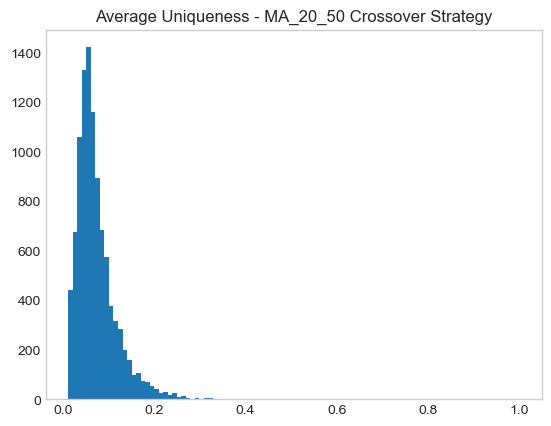

In [73]:
cont_train["tW"].hist(bins=100, grid=False)
plt.title(f"Average Uniqueness - MA_{fast_window}_{slow_window} Crossover Strategy");

In [74]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {k: {} for k in clfs.keys()}
print(rf.__class__.__name__, "Weighting Schemes")
all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_models = []

for scheme, sample_weights in weighting_schemes.items():
    best_score, best_model = None, None
    for param, clf in clfs.items():
        w = sample_weights.values
        cv_scores = ml_cross_val_score(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=w, 
            sample_weight_score=w,
            scoring="f1",
        )
        score = cv_scores.mean()
        cv_scores_d[param][scheme] = score
        best_score = max(best_score, score) if best_score is not None else score
        if score == best_score:
            best_model = param
        all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
    best_models.append(best_model)
    print(f"{scheme} {best_model} model achieved the best f1 score of {best_score:.6f}")

print()
pprint(all_clf_scores_df, sort_dicts=False)
best_model = max(best_models, key=best_models.count)
best_clf = clone(clfs[best_model])
print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

RandomForestClassifier Weighting Schemes
unweighted balanced_subsample model achieved the best f1 score of 0.405778
uniqueness balanced_subsample model achieved the best f1 score of 0.326313
return combined model achieved the best f1 score of 0.674708

                           unweighted         uniqueness             return
standard            0.000000 ± 0.0000  0.000000 ± 0.0000  0.480684 ± 0.1373
balanced_subsample  0.405778 ± 0.0620  0.326313 ± 0.0933  0.674708 ± 0.0518
max_samples         0.000000 ± 0.0000  0.000000 ± 0.0000  0.291804 ± 0.1409
combined            0.358043 ± 0.0838  0.249652 ± 0.1109  0.674708 ± 0.0518

Selected Best Classifier (balanced_subsample): RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       min_weight_fraction_leaf=0.05, n_jobs=-1,
                       random_state=42)


In [ ]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = ml_cross_val_scores_all(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores['f1'].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.6f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best f1 score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.5640 ± 0.081   0.6234 ± 0.070   0.5116 ± 0.063
pwa            0.5954 ± 0.103   0.7045 ± 0.070   0.5103 ± 0.065
neg_log_loss  -0.6810 ± 0.025  -0.6501 ± 0.024  -0.7781 ± 0.058
precision      0.3450 ± 0.036   0.3223 ± 0.046   0.5116 ± 0.063
recall         0.5335 ± 0.186   0.3749 ± 0.181   1.0000 ± 0.000
f1             0.4058 ± 0.062   0.3263 ± 0.093   0.6747 ± 0.052

return model achieved the best f1 score of 0.674708



In [76]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 393.0, 'FP': 328.0, 'FN': 110.0, 'TP': 185.0},
                {'fold': 2, 'TN': 483.0, 'FP': 248.0, 'FN': 158.0, 'TP': 127.0},
                {'fold': 3, 'TN': 450.0, 'FP': 279.0, 'FN': 156.0, 'TP': 131.0},
                {'fold': 4, 'TN': 578.0, 'FP': 161.0, 'FN': 187.0, 'TP': 90.0},
                {'fold': 5, 'TN': 139.0, 'FP': 482.0, 'FN': 80.0, 'TP': 315.0},
                {'fold': 6, 'TN': 336.0, 'FP': 419.0, 'FN': 91.0, 'TP': 170.0},
                {'fold': 7, 'TN': 518.0, 'FP': 229.0, 'FN': 158.0, 'TP': 111.0},
                {'fold': 8, 'TN': 596.0, 'FP': 127.0, 'FN': 205.0, 'TP': 88.0},
                {'fold': 9, 'TN': 480.0, 'FP': 267.0, 'FN': 150.0, 'TP': 119.0},
                {'fold': 10,
                 'TN': 129.0,
                 'FP': 554.0,
                 'FN': 41.0,
                 'TP': 292.0}],
 'uniqueness': [{'fold': 1, 'TN': 30.15, 'FP': 15.23, 'FN': 8.09, 'TP': 8.55},
                {'fold': 2, 'TN': 38.07, 'FP':

In [77]:
winsound.Beep(1000, 1000)